# vLife Virtusa

## Evidence based classification of  Genetic Variations 
### Usecase Description
<p> When a patient seems to have cancer,  a tumor sample is taken from the patient and it goes through genetic sequencing of DNA. Once sequenced, a tumor can have thousands of genetic mutations. A ‘mutation’ is small change in gene which causes cancer. Now with the help of the gene and its variation, we classify which class(total we have 9 classes) it belongs to. Only some classes belong to cancer. </p>

### Data Source
Data for this usecase can be found [here](https://www.kaggle.com/c/msk-redefining-cancer-treatment/data).

### Dataset Description
> File descriptions
 - **training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)**
 - **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
  - **test_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations)
 - **test_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

### Necessary Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np

import nltk
nltk.download('stopwords')

import math
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from collections import Counter
from scipy.sparse import hstack

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import normalized_mutual_info_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv('./data/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head(10)

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [3]:
data['Gene'].nunique()

264

In [4]:
data_text=pd.read_csv("./data/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head(10)

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


### 1.Exploratory Data Analysis
#### Data Preprocessing & Clean

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import datetime
start=datetime.datetime.now()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',datetime.datetime.now() - start, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 0:02:43.165075 seconds


In [7]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [10]:
result.iloc[1109]

ID                   1109
Gene                FANCA
Variation          S1088F
Class                   1
TEXT         FANCA S1088F
Name: 1109, dtype: object

In [11]:
result=pd.read_csv('final_data.csv')

In [12]:
result['combine']=result['Gene']+' '+result['Variation']+' '+result['TEXT']

In [20]:
result['Gene'][46]

'PTPRT'

In [21]:
result['Variation'][46]

'T844M'

In [22]:
result['TEXT'][46]

'introduction preceding hematologic disorders documented one quarter adults acute myeloid leukemia aml 1 however unknown proportion amls apparently arise de novo may developed undiscovered abnormal hematopoiesis mutations cbl encoding e3 ubiquitin ligase found 10 20 chronic myelomonocytic leukemia cmml juvenile myelomonocytic leukemia jmml patients 2 7 germline cbl mutations cause cbl syndrome recapitulates features ras mapk pathway disorders predisposes jmml 8 10 aml cbl mutations rare associated inv 16 11 14 describe development aml adult cbl syndrome jmml typical loss wild type wt cbl bone marrow methods written informed consent patient included present study obtained sample storage analyses sampling approved local ethics committee study conducted accordance declaration helsinki karyotype mutations npm1 flt3 tyrosine kinase domain internal tandem duplication cebpa cbl cbfb myh11 expression relative abl1 assessed described elsewhere 15 18 cbl mutated wt allelic ratios determined usin

In [16]:
result1=result[['combine','Class']]

In [19]:
result1['combine'][46]

'PTPRT T844M introduction preceding hematologic disorders documented one quarter adults acute myeloid leukemia aml 1 however unknown proportion amls apparently arise de novo may developed undiscovered abnormal hematopoiesis mutations cbl encoding e3 ubiquitin ligase found 10 20 chronic myelomonocytic leukemia cmml juvenile myelomonocytic leukemia jmml patients 2 7 germline cbl mutations cause cbl syndrome recapitulates features ras mapk pathway disorders predisposes jmml 8 10 aml cbl mutations rare associated inv 16 11 14 describe development aml adult cbl syndrome jmml typical loss wild type wt cbl bone marrow methods written informed consent patient included present study obtained sample storage analyses sampling approved local ethics committee study conducted accordance declaration helsinki karyotype mutations npm1 flt3 tyrosine kinase domain internal tandem duplication cebpa cbl cbfb myh11 expression relative abl1 assessed described elsewhere 15 18 cbl mutated wt allelic ratios det

In [14]:
result1.to_csv('train.csv',index=False)

## 2. Predictive Models

#### Vectorization and Build Base line Model

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,max_features=35000)

In [16]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(result['combine'], result['Class'], test_size=0.2, random_state=9)

In [17]:
result['combine']

0       FAM58A Truncating Mutations cyclin dependent k...
1       CBL W802* abstract background non small cell l...
2       CBL Q249E abstract background non small cell l...
3       CBL N454D recent evidence demonstrated acquire...
4       CBL L399V oncogenic mutations monomeric casita...
5       CBL V391I oncogenic mutations monomeric casita...
6       CBL V430M oncogenic mutations monomeric casita...
7       CBL Deletion cbl negative regulator activated ...
8       CBL Y371H abstract juvenile myelomonocytic leu...
9       CBL C384R abstract juvenile myelomonocytic leu...
10      CBL P395A oncogenic mutations monomeric casita...
11      CBL K382E noonan syndrome autosomal dominant c...
12      CBL R420Q noonan syndrome autosomal dominant c...
13      CBL C381A noonan syndrome autosomal dominant c...
14      CBL P428L oncogenic mutations monomeric casita...
15      CBL D390Y noonan syndrome autosomal dominant c...
16      CBL Truncating Mutations determine residual cy...
17      CBL Q3

In [19]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)
#xval_tfidf

In [20]:
xtrain_tfidf.shape

(2656, 35000)

In [21]:
lr = OneVsRestClassifier(RandomForestClassifier())

In [36]:
lr.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=None)

In [85]:
import pickle
pickle.dump(lr,open('lr_model.pkl','wb'))

In [42]:
y_pred = lr.predict(xval_tfidf)
accuracy_score(yval,y_pred)

0.45263157894736844

In [43]:
y_pred = lr.predict(xval_tfidf)
accuracy_score(yval,y_pred)

0.45263157894736844

In [44]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y=lb.fit_transform(result['Class'])
#Y=label_binarize(result['Class'],classes=[1,2,3,4,5,6,7,8,9])

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,max_features=45000)

In [46]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(result['combine'], Y, test_size=0.2, random_state=9)

In [47]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)
#xval_tfidf
xtrain_tfidf.shape

(2656, 45000)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
lr=OneVsRestClassifier(LogisticRegression())
rf = OneVsRestClassifier(RandomForestClassifier())
svm = OneVsRestClassifier(SVC())
gnb = OneVsRestClassifier(GaussianNB())
knn = OneVsRestClassifier(KNeighborsClassifier())

## 3. Model Selection
#### Logistic Regression

In [49]:
lr.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [77]:
xtrain_tfidf.shape

(2656, 45000)

In [76]:
import pickle
pickle.dump(lr,open('lr_model.pkl','wb'))

In [71]:
y_pred1 = lr.predict_proba(xval_tfidf)
# accuracy_score(yval,y_pred)

In [72]:
y_pred1

array([[0.24336125, 0.1191084 , 0.01992638, ..., 0.19862603, 0.00833847,
        0.0128977 ],
       [0.04793002, 0.52705931, 0.01711432, ..., 0.37260431, 0.00294991,
        0.00318196],
       [0.10265924, 0.14497408, 0.02034161, ..., 0.39488395, 0.00381541,
        0.00453775],
       ...,
       [0.07217979, 0.11719254, 0.01475613, ..., 0.25640356, 0.0069207 ,
        0.00875415],
       [0.30577528, 0.05775468, 0.02272429, ..., 0.12016891, 0.00283228,
        0.00302405],
       [0.53457967, 0.01005746, 0.03477403, ..., 0.00730125, 0.00668241,
        0.00901641]])

In [73]:
lb.inverse_transform(np.stack([y_pred1[0]]))[0]

1

In [74]:
roc_auc_score(yval, y_pred1)

0.8759005438723265

In [75]:
accuracy_score(lb.inverse_transform(yval),lb.inverse_transform(y_pred1))

0.5939849624060151

#### Random Forest

In [57]:
rf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=None)

In [58]:
y_pred2 = rf.predict_proba(xval_tfidf)

In [59]:
roc_auc_score(yval, y_pred2)

0.8330407488316522

In [60]:
accuracy_score(lb.inverse_transform(yval),lb.inverse_transform(y_pred2))

0.6225563909774436

#### SVM

In [550]:
svm.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [ ]:
y_pred3 = svm.predict_proba(xval_tfidf.toarray())

In [ ]:
roc_auc_score(yval, y_pred3)

In [ ]:
accuracy_score(lb.inverse_transform(yval),lb.inverse_transform(y_pred3))

#### Gaussian

In [51]:
gnb.fit(xtrain_tfidf.toarray(), ytrain)

OneVsRestClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
          n_jobs=None)

In [52]:
y_pred4 = gnb.predict_proba(xval_tfidf.toarray())

In [53]:
roc_auc_score(yval, y_pred4)

0.774337391597264

In [54]:
accuracy_score(lb.inverse_transform(yval),lb.inverse_transform(y_pred4))

0.49022556390977445

#### K Nearest Neighbor

In [55]:
knn.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          n_jobs=None)

In [56]:
y_pred5 = knn.predict_proba(xval_tfidf)

In [57]:
roc_auc_score(yval, y_pred5)

0.8276394520246101

In [58]:
accuracy_score(lb.inverse_transform(yval),lb.inverse_transform(y_pred5))

0.6120300751879699

## 3. Generating Predictions for Baseline Models
#### For Logistic Regression

In [64]:
print(lb.inverse_transform(yval),'\n\n',lb.inverse_transform(y_pred1))

[4 7 5 1 7 1 4 7 6 7 7 2 4 2 1 4 4 2 1 7 7 4 5 7 1 2 2 6 7 7 4 7 6 4 4 4 7
 6 1 1 5 6 4 4 4 6 7 2 4 4 2 7 5 9 4 8 7 4 1 1 4 7 1 7 7 2 7 7 6 1 4 8 4 7
 7 1 7 7 6 5 5 6 7 7 1 3 7 4 7 2 4 7 7 7 6 1 6 4 4 4 4 2 1 7 1 4 6 1 4 6 7
 4 1 4 5 4 7 6 2 2 7 1 6 1 1 2 4 7 7 2 6 8 4 1 2 7 1 2 7 2 1 1 4 4 7 7 1 7
 7 1 4 4 6 7 5 1 5 4 4 2 1 4 6 7 7 1 1 6 7 4 7 6 5 2 6 5 6 7 5 6 5 4 6 5 5
 7 5 4 7 6 4 1 2 7 7 4 2 7 4 6 4 1 2 4 7 7 6 7 1 6 7 7 1 7 1 4 7 1 4 4 5 2
 1 4 7 7 1 1 1 1 2 1 2 1 2 2 4 2 4 7 1 1 5 2 7 7 4 1 6 6 4 4 6 7 4 3 5 1 2
 5 4 5 7 2 4 5 2 1 7 1 2 7 4 6 7 3 1 1 9 2 4 1 7 4 4 1 4 7 7 6 7 4 4 4 6 6
 7 4 7 7 6 9 7 6 4 1 1 7 7 4 4 2 1 2 7 7 5 6 4 7 6 4 2 6 4 7 7 7 2 2 2 1 4
 7 1 7 1 6 7 7 6 1 7 5 7 1 2 8 7 7 4 2 7 1 6 6 7 1 3 2 2 4 1 1 7 1 2 1 5 7
 1 1 7 7 7 1 6 2 2 9 1 7 7 4 1 1 7 7 7 2 3 1 1 7 1 9 6 1 7 2 7 7 2 1 6 7 1
 7 4 7 7 2 3 2 1 1 7 4 7 1 7 5 1 2 5 4 2 7 3 2 2 7 4 9 7 2 1 4 5 4 6 1 5 5
 4 6 4 7 6 4 6 5 4 5 4 7 7 4 1 2 2 2 4 3 7 2 6 7 1 3 4 5 1 2 7 4 2 6 2 7 7
 4 2 1 7 3 7 7 7 7 4 3 7 

In [65]:
xvalindex=xval.index

In [67]:

# import the pyplot library

import matplotlib.pyplot as plotter

In [88]:
list(y_pred1[0]*100)[0]

24.336125084394407

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  1  is 
Predicted: 24.336125084394407 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  2  is 
Predicted: 11.910840244824456 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  3  is 
Predicted: 1.9926378374009328 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  4  is 
Predicted: 22.255537564564875 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  5  is 
Predicted: 3.0596524163204526 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  6  is 
Predicted: 4.470724318237454 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  7  is 
Predicted: 19.862602640841867 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  9  is 
Predicted: 1.289769827967997 



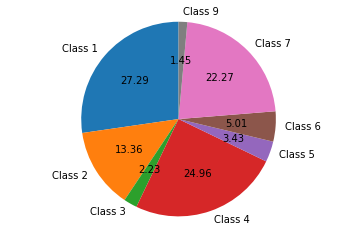

Predicted: Class 1
Actual: Class 4



Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  1  is 
Predicted: 4.793001970492381 

Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  2  is 
Predicted: 52.705930726505834 

Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  3  is 
Predicted: 1.7114322502537038 

Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  4  is 
Predicted: 3.1379205790301032 

Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  5  is 
Predicted: 5.096337007226045 

Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  6  is 
Predicted: 6.63133677865705 

Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  7  is 
Predicted: 37.26043068675776 



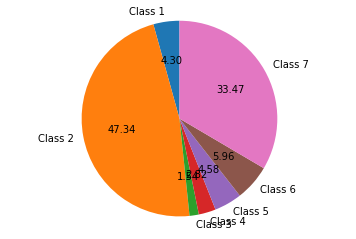

Predicted: Class 2
Actual: Class 7



Probability that the Gene  RET  with variation  D631A  belongs to class  1  is 
Predicted: 10.265923603217871 

Probability that the Gene  RET  with variation  D631A  belongs to class  2  is 
Predicted: 14.497407599802983 

Probability that the Gene  RET  with variation  D631A  belongs to class  3  is 
Predicted: 2.0341613950061355 

Probability that the Gene  RET  with variation  D631A  belongs to class  4  is 
Predicted: 13.954013987673797 

Probability that the Gene  RET  with variation  D631A  belongs to class  5  is 
Predicted: 12.33102980581048 

Probability that the Gene  RET  with variation  D631A  belongs to class  6  is 
Predicted: 5.036203900116588 

Probability that the Gene  RET  with variation  D631A  belongs to class  7  is 
Predicted: 39.48839549277111 



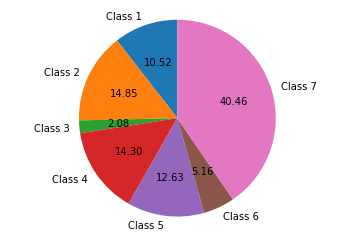

Predicted: Class 7
Actual: Class 5



Probability that the Gene  NF2  with variation  L64P  belongs to class  1  is 
Predicted: 22.58722625364395 

Probability that the Gene  NF2  with variation  L64P  belongs to class  2  is 
Predicted: 10.430504837034473 

Probability that the Gene  NF2  with variation  L64P  belongs to class  3  is 
Predicted: 1.8207069192550833 

Probability that the Gene  NF2  with variation  L64P  belongs to class  4  is 
Predicted: 10.155905861167696 

Probability that the Gene  NF2  with variation  L64P  belongs to class  5  is 
Predicted: 10.195175072095182 

Probability that the Gene  NF2  with variation  L64P  belongs to class  6  is 
Predicted: 10.85294497225205 

Probability that the Gene  NF2  with variation  L64P  belongs to class  7  is 
Predicted: 21.17506637657796 



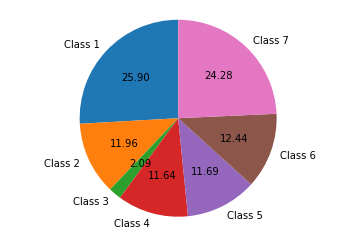

Predicted: Class 1
Actual: Class 1



Probability that the Gene  MET  with variation  Overexpression  belongs to class  1  is 
Predicted: 8.827568803531062 

Probability that the Gene  MET  with variation  Overexpression  belongs to class  2  is 
Predicted: 16.648579509120506 

Probability that the Gene  MET  with variation  Overexpression  belongs to class  3  is 
Predicted: 1.6364853738311431 

Probability that the Gene  MET  with variation  Overexpression  belongs to class  4  is 
Predicted: 9.975362771124113 

Probability that the Gene  MET  with variation  Overexpression  belongs to class  5  is 
Predicted: 1.658441673669863 

Probability that the Gene  MET  with variation  Overexpression  belongs to class  6  is 
Predicted: 4.266237751565845 

Probability that the Gene  MET  with variation  Overexpression  belongs to class  7  is 
Predicted: 59.72172522049271 

Probability that the Gene  MET  with variation  Overexpression  belongs to class  9  is 
Predicted: 1.129349541686471 



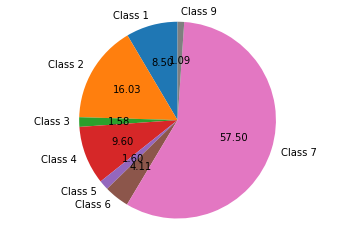

Predicted: Class 7
Actual: Class 7



Probability that the Gene  TP53  with variation  S241F  belongs to class  1  is 
Predicted: 47.378871949691664 

Probability that the Gene  TP53  with variation  S241F  belongs to class  2  is 
Predicted: 3.9700420621159154 

Probability that the Gene  TP53  with variation  S241F  belongs to class  3  is 
Predicted: 1.474405163190311 

Probability that the Gene  TP53  with variation  S241F  belongs to class  4  is 
Predicted: 44.45553420466085 

Probability that the Gene  TP53  with variation  S241F  belongs to class  5  is 
Predicted: 1.6977293499425463 

Probability that the Gene  TP53  with variation  S241F  belongs to class  6  is 
Predicted: 3.711291709069147 

Probability that the Gene  TP53  with variation  S241F  belongs to class  7  is 
Predicted: 3.6511630651119695 

Probability that the Gene  TP53  with variation  S241F  belongs to class  9  is 
Predicted: 1.2581684360690513 



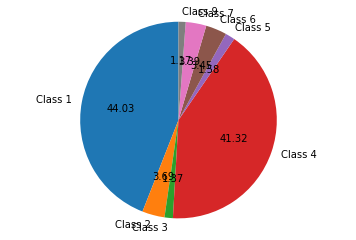

Predicted: Class 1
Actual: Class 1



Probability that the Gene  TGFBR2  with variation  D404G  belongs to class  1  is 
Predicted: 20.663815113388846 

Probability that the Gene  TGFBR2  with variation  D404G  belongs to class  2  is 
Predicted: 9.922356656561586 

Probability that the Gene  TGFBR2  with variation  D404G  belongs to class  3  is 
Predicted: 2.2461598982470847 

Probability that the Gene  TGFBR2  with variation  D404G  belongs to class  4  is 
Predicted: 29.72587311564439 

Probability that the Gene  TGFBR2  with variation  D404G  belongs to class  5  is 
Predicted: 3.639159347155411 

Probability that the Gene  TGFBR2  with variation  D404G  belongs to class  6  is 
Predicted: 4.341690020714067 

Probability that the Gene  TGFBR2  with variation  D404G  belongs to class  7  is 
Predicted: 17.492640897692134 

Probability that the Gene  TGFBR2  with variation  D404G  belongs to class  9  is 
Predicted: 1.3217070706975225 



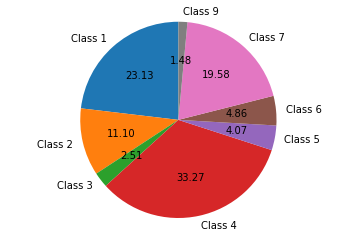

Predicted: Class 4
Actual: Class 4



Probability that the Gene  EGFR  with variation  EGFRvIII  belongs to class  1  is 
Predicted: 5.9067490137767535 

Probability that the Gene  EGFR  with variation  EGFRvIII  belongs to class  2  is 
Predicted: 10.577594663351608 

Probability that the Gene  EGFR  with variation  EGFRvIII  belongs to class  3  is 
Predicted: 1.643027800139192 

Probability that the Gene  EGFR  with variation  EGFRvIII  belongs to class  4  is 
Predicted: 9.99126181974269 

Probability that the Gene  EGFR  with variation  EGFRvIII  belongs to class  5  is 
Predicted: 2.691636578235679 

Probability that the Gene  EGFR  with variation  EGFRvIII  belongs to class  6  is 
Predicted: 2.849765656146081 

Probability that the Gene  EGFR  with variation  EGFRvIII  belongs to class  7  is 
Predicted: 62.42735260337335 



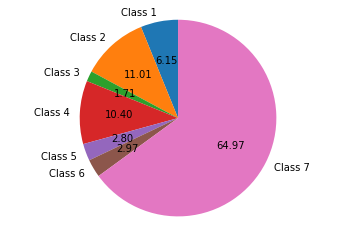

Predicted: Class 7
Actual: Class 7



Probability that the Gene  BRCA2  with variation  L929S  belongs to class  1  is 
Predicted: 9.04143233137556 

Probability that the Gene  BRCA2  with variation  L929S  belongs to class  2  is 
Predicted: 5.647245110663612 

Probability that the Gene  BRCA2  with variation  L929S  belongs to class  3  is 
Predicted: 1.8642533077860786 

Probability that the Gene  BRCA2  with variation  L929S  belongs to class  4  is 
Predicted: 5.149158001720256 

Probability that the Gene  BRCA2  with variation  L929S  belongs to class  5  is 
Predicted: 17.568414210542937 

Probability that the Gene  BRCA2  with variation  L929S  belongs to class  6  is 
Predicted: 55.958118914459966 

Probability that the Gene  BRCA2  with variation  L929S  belongs to class  7  is 
Predicted: 7.185410406971937 



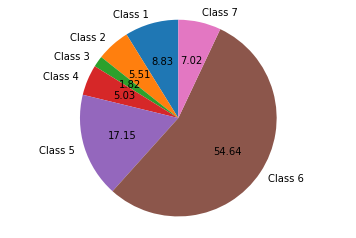

Predicted: Class 6
Actual: Class 6



Probability that the Gene  ERG  with variation  FUS-ERG Fusion  belongs to class  1  is 
Predicted: 18.83563239525014 

Probability that the Gene  ERG  with variation  FUS-ERG Fusion  belongs to class  2  is 
Predicted: 16.383326896444224 

Probability that the Gene  ERG  with variation  FUS-ERG Fusion  belongs to class  3  is 
Predicted: 1.9210324522627307 

Probability that the Gene  ERG  with variation  FUS-ERG Fusion  belongs to class  4  is 
Predicted: 11.994988017500418 

Probability that the Gene  ERG  with variation  FUS-ERG Fusion  belongs to class  5  is 
Predicted: 2.891202840630883 

Probability that the Gene  ERG  with variation  FUS-ERG Fusion  belongs to class  6  is 
Predicted: 3.1946989612621386 

Probability that the Gene  ERG  with variation  FUS-ERG Fusion  belongs to class  7  is 
Predicted: 41.12985068752783 

Probability that the Gene  ERG  with variation  FUS-ERG Fusion  belongs to class  9  is 
Predicted: 1.540444636249234 

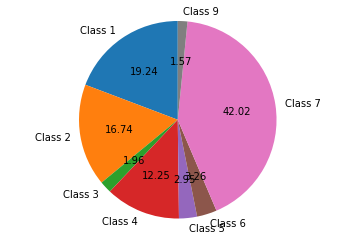

Predicted: Class 7
Actual: Class 7



Probability that the Gene  CDK4  with variation  R24C  belongs to class  1  is 
Predicted: 17.363767738266542 

Probability that the Gene  CDK4  with variation  R24C  belongs to class  2  is 
Predicted: 9.504522879323055 

Probability that the Gene  CDK4  with variation  R24C  belongs to class  3  is 
Predicted: 1.7616807687535887 

Probability that the Gene  CDK4  with variation  R24C  belongs to class  4  is 
Predicted: 30.48897950419116 

Probability that the Gene  CDK4  with variation  R24C  belongs to class  5  is 
Predicted: 3.0010844888771127 

Probability that the Gene  CDK4  with variation  R24C  belongs to class  6  is 
Predicted: 4.173808488336148 

Probability that the Gene  CDK4  with variation  R24C  belongs to class  7  is 
Predicted: 23.184269967164674 

Probability that the Gene  CDK4  with variation  R24C  belongs to class  9  is 
Predicted: 1.2298375116609739 



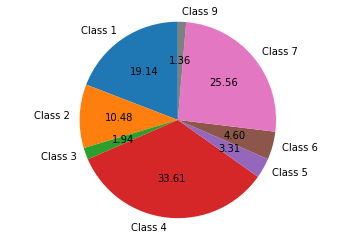

Predicted: Class 4
Actual: Class 7



Probability that the Gene  EGFR  with variation  N826Y  belongs to class  1  is 
Predicted: 1.7123624393942334 

Probability that the Gene  EGFR  with variation  N826Y  belongs to class  2  is 
Predicted: 31.202434724818673 

Probability that the Gene  EGFR  with variation  N826Y  belongs to class  3  is 
Predicted: 1.049963942829678 

Probability that the Gene  EGFR  with variation  N826Y  belongs to class  4  is 
Predicted: 3.7909780802479274 

Probability that the Gene  EGFR  with variation  N826Y  belongs to class  5  is 
Predicted: 2.165753078147905 

Probability that the Gene  EGFR  with variation  N826Y  belongs to class  6  is 
Predicted: 2.01638194396063 

Probability that the Gene  EGFR  with variation  N826Y  belongs to class  7  is 
Predicted: 66.6476231504227 



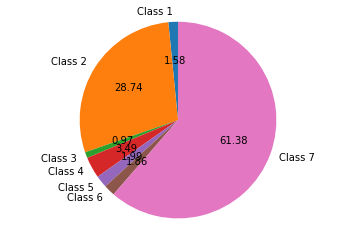

Predicted: Class 7
Actual: Class 2



Probability that the Gene  TP53  with variation  H193N  belongs to class  1  is 
Predicted: 48.93133090470219 

Probability that the Gene  TP53  with variation  H193N  belongs to class  2  is 
Predicted: 3.6002900886426077 

Probability that the Gene  TP53  with variation  H193N  belongs to class  3  is 
Predicted: 1.279008477026846 

Probability that the Gene  TP53  with variation  H193N  belongs to class  4  is 
Predicted: 25.66918884348682 

Probability that the Gene  TP53  with variation  H193N  belongs to class  5  is 
Predicted: 4.364677398695013 

Probability that the Gene  TP53  with variation  H193N  belongs to class  6  is 
Predicted: 5.635051566050244 

Probability that the Gene  TP53  with variation  H193N  belongs to class  7  is 
Predicted: 4.624900150016493 

Probability that the Gene  TP53  with variation  H193N  belongs to class  9  is 
Predicted: 1.0725213759879126 



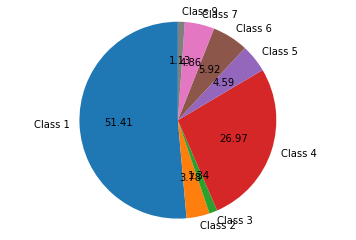

Predicted: Class 1
Actual: Class 4



Probability that the Gene  HRAS  with variation  T58I  belongs to class  1  is 
Predicted: 16.43112114977191 

Probability that the Gene  HRAS  with variation  T58I  belongs to class  2  is 
Predicted: 18.63707957432271 

Probability that the Gene  HRAS  with variation  T58I  belongs to class  3  is 
Predicted: 2.0788544953255896 

Probability that the Gene  HRAS  with variation  T58I  belongs to class  4  is 
Predicted: 19.963895496529787 

Probability that the Gene  HRAS  with variation  T58I  belongs to class  5  is 
Predicted: 3.567404382326128 

Probability that the Gene  HRAS  with variation  T58I  belongs to class  6  is 
Predicted: 4.56172451636858 

Probability that the Gene  HRAS  with variation  T58I  belongs to class  7  is 
Predicted: 20.729235713555966 

Probability that the Gene  HRAS  with variation  T58I  belongs to class  9  is 
Predicted: 1.2665729047660395 



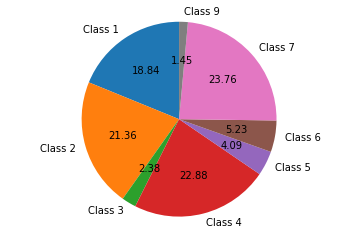

Predicted: Class 7
Actual: Class 2



Probability that the Gene  ERCC2  with variation  D513Y  belongs to class  1  is 
Predicted: 76.42792445417868 

Probability that the Gene  ERCC2  with variation  D513Y  belongs to class  2  is 
Predicted: 3.7254763920982037 

Probability that the Gene  ERCC2  with variation  D513Y  belongs to class  3  is 
Predicted: 1.965223981594286 

Probability that the Gene  ERCC2  with variation  D513Y  belongs to class  4  is 
Predicted: 9.377866041459926 

Probability that the Gene  ERCC2  with variation  D513Y  belongs to class  5  is 
Predicted: 6.6768112267551905 

Probability that the Gene  ERCC2  with variation  D513Y  belongs to class  6  is 
Predicted: 4.305450597871417 

Probability that the Gene  ERCC2  with variation  D513Y  belongs to class  7  is 
Predicted: 4.378562888252649 

Probability that the Gene  ERCC2  with variation  D513Y  belongs to class  9  is 
Predicted: 1.0408444416926348 



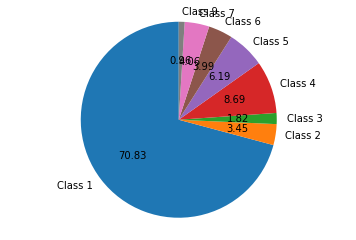

Predicted: Class 1
Actual: Class 1



Probability that the Gene  PTEN  with variation  G165R  belongs to class  1  is 
Predicted: 3.974539831722204 

Probability that the Gene  PTEN  with variation  G165R  belongs to class  2  is 
Predicted: 2.581541484563629 

Probability that the Gene  PTEN  with variation  G165R  belongs to class  3  is 
Predicted: 1.7763105944689865 

Probability that the Gene  PTEN  with variation  G165R  belongs to class  4  is 
Predicted: 91.32445526837155 

Probability that the Gene  PTEN  with variation  G165R  belongs to class  5  is 
Predicted: 1.911229173010638 

Probability that the Gene  PTEN  with variation  G165R  belongs to class  6  is 
Predicted: 2.018480765856701 

Probability that the Gene  PTEN  with variation  G165R  belongs to class  7  is 
Predicted: 4.079034953386495 



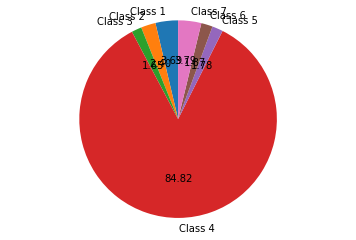

Predicted: Class 4
Actual: Class 4



Probability that the Gene  PTEN  with variation  M35R  belongs to class  1  is 
Predicted: 3.6441128088732766 

Probability that the Gene  PTEN  with variation  M35R  belongs to class  2  is 
Predicted: 2.1225714383652226 

Probability that the Gene  PTEN  with variation  M35R  belongs to class  3  is 
Predicted: 3.6669106328061383 

Probability that the Gene  PTEN  with variation  M35R  belongs to class  4  is 
Predicted: 88.71099818601601 

Probability that the Gene  PTEN  with variation  M35R  belongs to class  5  is 
Predicted: 1.8105221822367419 

Probability that the Gene  PTEN  with variation  M35R  belongs to class  6  is 
Predicted: 1.7037940867968429 

Probability that the Gene  PTEN  with variation  M35R  belongs to class  7  is 
Predicted: 3.4194960897102984 



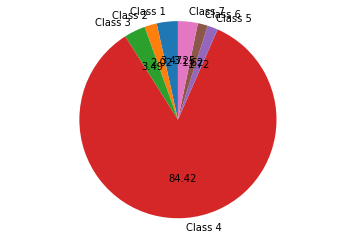

Predicted: Class 4
Actual: Class 4



Probability that the Gene  EGFR  with variation  G863S  belongs to class  1  is 
Predicted: 6.774928402934679 

Probability that the Gene  EGFR  with variation  G863S  belongs to class  2  is 
Predicted: 44.79097225086582 

Probability that the Gene  EGFR  with variation  G863S  belongs to class  3  is 
Predicted: 1.8547855937235087 

Probability that the Gene  EGFR  with variation  G863S  belongs to class  4  is 
Predicted: 6.111450060622647 

Probability that the Gene  EGFR  with variation  G863S  belongs to class  5  is 
Predicted: 1.9477475151977883 

Probability that the Gene  EGFR  with variation  G863S  belongs to class  6  is 
Predicted: 2.1047288864622105 

Probability that the Gene  EGFR  with variation  G863S  belongs to class  7  is 
Predicted: 24.820275995521587 



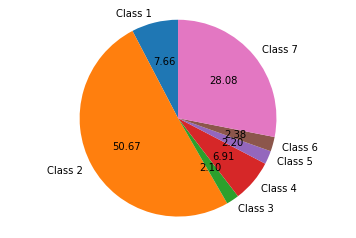

Predicted: Class 2
Actual: Class 2



Probability that the Gene  BRCA2  with variation  R2842C  belongs to class  1  is 
Predicted: 21.59274917183537 

Probability that the Gene  BRCA2  with variation  R2842C  belongs to class  2  is 
Predicted: 6.106895491292644 

Probability that the Gene  BRCA2  with variation  R2842C  belongs to class  3  is 
Predicted: 3.2823731038669637 

Probability that the Gene  BRCA2  with variation  R2842C  belongs to class  4  is 
Predicted: 11.308802295379659 

Probability that the Gene  BRCA2  with variation  R2842C  belongs to class  5  is 
Predicted: 24.92608536523372 

Probability that the Gene  BRCA2  with variation  R2842C  belongs to class  6  is 
Predicted: 14.692642083099141 

Probability that the Gene  BRCA2  with variation  R2842C  belongs to class  7  is 
Predicted: 10.362670518240918 



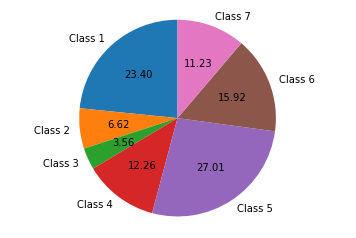

Predicted: Class 5
Actual: Class 1



Probability that the Gene  ROS1  with variation  ROS1-CD74 Fusion  belongs to class  1  is 
Predicted: 2.3017124120893446 

Probability that the Gene  ROS1  with variation  ROS1-CD74 Fusion  belongs to class  2  is 
Predicted: 54.42607069719798 

Probability that the Gene  ROS1  with variation  ROS1-CD74 Fusion  belongs to class  3  is 
Predicted: 2.0614219872307284 

Probability that the Gene  ROS1  with variation  ROS1-CD74 Fusion  belongs to class  4  is 
Predicted: 2.4934801595309755 

Probability that the Gene  ROS1  with variation  ROS1-CD74 Fusion  belongs to class  5  is 
Predicted: 2.2695938930585293 

Probability that the Gene  ROS1  with variation  ROS1-CD74 Fusion  belongs to class  6  is 
Predicted: 2.5347004106451014 

Probability that the Gene  ROS1  with variation  ROS1-CD74 Fusion  belongs to class  7  is 
Predicted: 59.50380154894943 



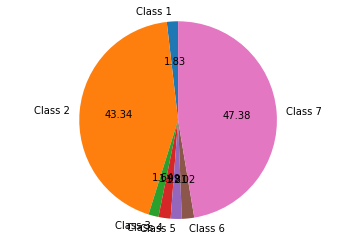

Predicted: Class 7
Actual: Class 7



Probability that the Gene  AKT2  with variation  D32H  belongs to class  1  is 
Predicted: 7.755390659203265 

Probability that the Gene  AKT2  with variation  D32H  belongs to class  2  is 
Predicted: 13.377511600120787 

Probability that the Gene  AKT2  with variation  D32H  belongs to class  3  is 
Predicted: 4.079912859649775 

Probability that the Gene  AKT2  with variation  D32H  belongs to class  4  is 
Predicted: 11.548687561124241 

Probability that the Gene  AKT2  with variation  D32H  belongs to class  5  is 
Predicted: 3.8614953290780956 

Probability that the Gene  AKT2  with variation  D32H  belongs to class  6  is 
Predicted: 2.763370923389952 

Probability that the Gene  AKT2  with variation  D32H  belongs to class  7  is 
Predicted: 32.19755408891472 

Probability that the Gene  AKT2  with variation  D32H  belongs to class  8  is 
Predicted: 1.102635517524781 

Probability that the Gene  AKT2  with variation  D32H  belongs to class

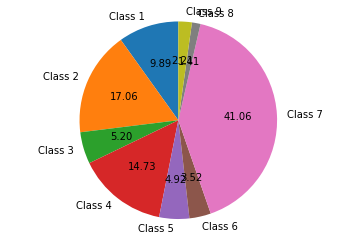

Predicted: Class 7
Actual: Class 7



Probability that the Gene  CDH1  with variation  D254N  belongs to class  1  is 
Predicted: 41.382317382581626 

Probability that the Gene  CDH1  with variation  D254N  belongs to class  2  is 
Predicted: 5.039248913194484 

Probability that the Gene  CDH1  with variation  D254N  belongs to class  3  is 
Predicted: 2.969779810630913 

Probability that the Gene  CDH1  with variation  D254N  belongs to class  4  is 
Predicted: 26.98860795461875 

Probability that the Gene  CDH1  with variation  D254N  belongs to class  5  is 
Predicted: 4.796212311018105 

Probability that the Gene  CDH1  with variation  D254N  belongs to class  6  is 
Predicted: 4.406971785892677 

Probability that the Gene  CDH1  with variation  D254N  belongs to class  7  is 
Predicted: 6.236262783119127 

Probability that the Gene  CDH1  with variation  D254N  belongs to class  9  is 
Predicted: 1.199950575602145 



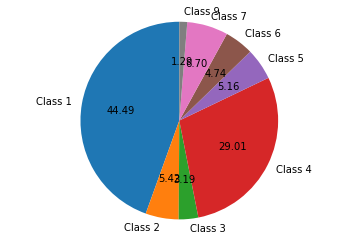

Predicted: Class 1
Actual: Class 4



Probability that the Gene  BRCA1  with variation  P1771L  belongs to class  1  is 
Predicted: 25.345532613115118 

Probability that the Gene  BRCA1  with variation  P1771L  belongs to class  2  is 
Predicted: 5.487530102612568 

Probability that the Gene  BRCA1  with variation  P1771L  belongs to class  3  is 
Predicted: 2.3395098422556413 

Probability that the Gene  BRCA1  with variation  P1771L  belongs to class  4  is 
Predicted: 11.824379262227792 

Probability that the Gene  BRCA1  with variation  P1771L  belongs to class  5  is 
Predicted: 25.800931579979892 

Probability that the Gene  BRCA1  with variation  P1771L  belongs to class  6  is 
Predicted: 13.240896080968117 

Probability that the Gene  BRCA1  with variation  P1771L  belongs to class  7  is 
Predicted: 10.783764567286134 



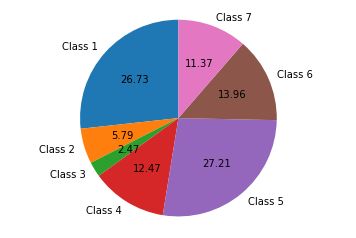

Predicted: Class 5
Actual: Class 5



Probability that the Gene  AKT1  with variation  L78T  belongs to class  1  is 
Predicted: 4.390750271547124 

Probability that the Gene  AKT1  with variation  L78T  belongs to class  2  is 
Predicted: 3.7964918971539467 

Probability that the Gene  AKT1  with variation  L78T  belongs to class  3  is 
Predicted: 8.749539666534158 

Probability that the Gene  AKT1  with variation  L78T  belongs to class  4  is 
Predicted: 5.31043547873357 

Probability that the Gene  AKT1  with variation  L78T  belongs to class  5  is 
Predicted: 6.315698842644865 

Probability that the Gene  AKT1  with variation  L78T  belongs to class  6  is 
Predicted: 2.6973805484128306 

Probability that the Gene  AKT1  with variation  L78T  belongs to class  7  is 
Predicted: 67.44838382993643 

Probability that the Gene  AKT1  with variation  L78T  belongs to class  8  is 
Predicted: 1.0479407987829392 

Probability that the Gene  AKT1  with variation  L78T  belongs to class 

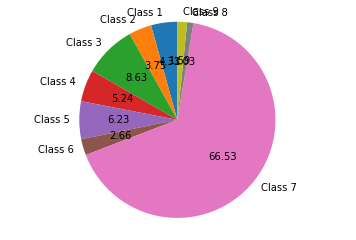

Predicted: Class 7
Actual: Class 7



Probability that the Gene  CTLA4  with variation  T17A  belongs to class  1  is 
Predicted: 24.517210333448503 

Probability that the Gene  CTLA4  with variation  T17A  belongs to class  2  is 
Predicted: 12.618433828938427 

Probability that the Gene  CTLA4  with variation  T17A  belongs to class  3  is 
Predicted: 2.502709479937178 

Probability that the Gene  CTLA4  with variation  T17A  belongs to class  4  is 
Predicted: 16.250160629591754 

Probability that the Gene  CTLA4  with variation  T17A  belongs to class  5  is 
Predicted: 3.204862145126191 

Probability that the Gene  CTLA4  with variation  T17A  belongs to class  6  is 
Predicted: 4.543018847638086 

Probability that the Gene  CTLA4  with variation  T17A  belongs to class  7  is 
Predicted: 16.01981338998326 

Probability that the Gene  CTLA4  with variation  T17A  belongs to class  9  is 
Predicted: 1.2753257932880815 



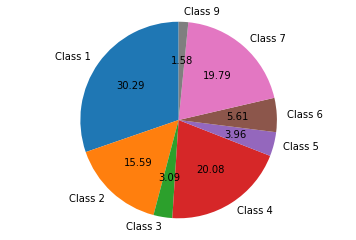

Predicted: Class 1
Actual: Class 1



Probability that the Gene  KIT  with variation  Y570H  belongs to class  1  is 
Predicted: 6.1315860196157965 

Probability that the Gene  KIT  with variation  Y570H  belongs to class  2  is 
Predicted: 44.914545967119665 

Probability that the Gene  KIT  with variation  Y570H  belongs to class  3  is 
Predicted: 1.5399524529510473 

Probability that the Gene  KIT  with variation  Y570H  belongs to class  4  is 
Predicted: 3.576960118279344 

Probability that the Gene  KIT  with variation  Y570H  belongs to class  5  is 
Predicted: 5.159598421422844 

Probability that the Gene  KIT  with variation  Y570H  belongs to class  6  is 
Predicted: 10.578100553340272 

Probability that the Gene  KIT  with variation  Y570H  belongs to class  7  is 
Predicted: 33.38166377242202 



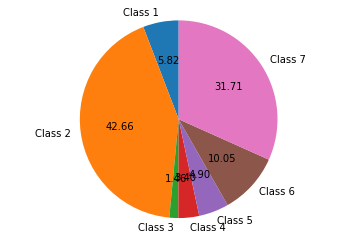

Predicted: Class 2
Actual: Class 2



Probability that the Gene  EGFR  with variation  S645C  belongs to class  1  is 
Predicted: 4.995383433350493 

Probability that the Gene  EGFR  with variation  S645C  belongs to class  2  is 
Predicted: 11.119302950933932 

Probability that the Gene  EGFR  with variation  S645C  belongs to class  3  is 
Predicted: 1.8937745483445205 

Probability that the Gene  EGFR  with variation  S645C  belongs to class  4  is 
Predicted: 14.524154930902148 

Probability that the Gene  EGFR  with variation  S645C  belongs to class  5  is 
Predicted: 4.268908916037518 

Probability that the Gene  EGFR  with variation  S645C  belongs to class  6  is 
Predicted: 2.574273459530309 

Probability that the Gene  EGFR  with variation  S645C  belongs to class  7  is 
Predicted: 34.93613614083848 



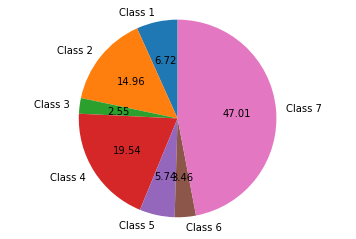

Predicted: Class 7
Actual: Class 2



Probability that the Gene  ERBB2  with variation  S1002R  belongs to class  1  is 
Predicted: 2.731338831848209 

Probability that the Gene  ERBB2  with variation  S1002R  belongs to class  2  is 
Predicted: 23.828097320147123 

Probability that the Gene  ERBB2  with variation  S1002R  belongs to class  3  is 
Predicted: 1.434072372790281 

Probability that the Gene  ERBB2  with variation  S1002R  belongs to class  4  is 
Predicted: 4.7026284139882994 

Probability that the Gene  ERBB2  with variation  S1002R  belongs to class  5  is 
Predicted: 4.230163395146934 

Probability that the Gene  ERBB2  with variation  S1002R  belongs to class  6  is 
Predicted: 43.349923066858324 

Probability that the Gene  ERBB2  with variation  S1002R  belongs to class  7  is 
Predicted: 20.270546312417164 

Probability that the Gene  ERBB2  with variation  S1002R  belongs to class  8  is 
Predicted: 1.1082678181374415 



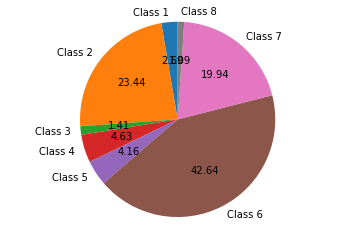

Predicted: Class 6
Actual: Class 6



Probability that the Gene  EGFR  with variation  D587H  belongs to class  1  is 
Predicted: 10.548295385240143 

Probability that the Gene  EGFR  with variation  D587H  belongs to class  2  is 
Predicted: 19.75003396431438 

Probability that the Gene  EGFR  with variation  D587H  belongs to class  3  is 
Predicted: 1.753068479641686 

Probability that the Gene  EGFR  with variation  D587H  belongs to class  4  is 
Predicted: 5.591872150473564 

Probability that the Gene  EGFR  with variation  D587H  belongs to class  5  is 
Predicted: 3.948246249241362 

Probability that the Gene  EGFR  with variation  D587H  belongs to class  6  is 
Predicted: 3.8801437776864613 

Probability that the Gene  EGFR  with variation  D587H  belongs to class  7  is 
Predicted: 34.251018455901836 



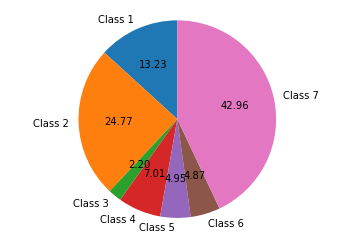

Predicted: Class 7
Actual: Class 7



Probability that the Gene  EGFR  with variation  Exon 19 deletion  belongs to class  1  is 
Predicted: 2.136221562784428 

Probability that the Gene  EGFR  with variation  Exon 19 deletion  belongs to class  2  is 
Predicted: 38.33165177224446 

Probability that the Gene  EGFR  with variation  Exon 19 deletion  belongs to class  4  is 
Predicted: 2.245571358636661 

Probability that the Gene  EGFR  with variation  Exon 19 deletion  belongs to class  5  is 
Predicted: 1.8382455013892123 

Probability that the Gene  EGFR  with variation  Exon 19 deletion  belongs to class  6  is 
Predicted: 1.8782282211868502 

Probability that the Gene  EGFR  with variation  Exon 19 deletion  belongs to class  7  is 
Predicted: 68.49953967656127 



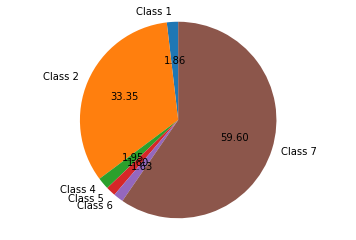

Predicted: Class 7
Actual: Class 7



Probability that the Gene  PTEN  with variation  V343L  belongs to class  1  is 
Predicted: 3.6438783245637554 

Probability that the Gene  PTEN  with variation  V343L  belongs to class  2  is 
Predicted: 2.122437165489485 

Probability that the Gene  PTEN  with variation  V343L  belongs to class  3  is 
Predicted: 3.6668334733113492 

Probability that the Gene  PTEN  with variation  V343L  belongs to class  4  is 
Predicted: 88.71236825521837 

Probability that the Gene  PTEN  with variation  V343L  belongs to class  5  is 
Predicted: 1.81041433452378 

Probability that the Gene  PTEN  with variation  V343L  belongs to class  6  is 
Predicted: 1.703739002570955 

Probability that the Gene  PTEN  with variation  V343L  belongs to class  7  is 
Predicted: 3.41937510177643 



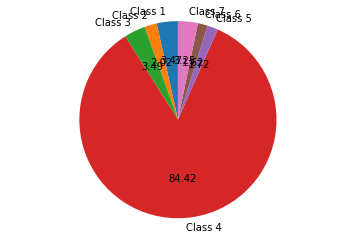

Predicted: Class 4
Actual: Class 4





In [81]:
j=0

for i in xvalindex:
    pie = []
    pie_labels = []
    for k in range(1,10):
        if list(map(int,y_pred1[j]*100))[k-1]!=0:
            print("Probability that the Gene ",result['Gene'].loc[i]," with variation ",result['Variation'].loc[i]," belongs to class ",k," is \nPredicted:",list(y_pred1[j]*100)[k-1],"\n")
            pie.append((y_pred1[j]*100)[k-1])
            pie_labels.append('Class ' + str(k))
    #pie_2 = [ '%.2f' % elem for elem in pie ]
    figureObject, axesObject = plotter.subplots()
    axesObject.pie(pie,labels=pie_labels,autopct='%1.2f',startangle=90)
    axesObject.axis('equal')
    plotter.show()
    print("Predicted: Class",lb.inverse_transform(np.array([y_pred1[j]]))[0])
    print("Actual: Class",lb.inverse_transform(np.array([yval[j]]))[0])
    print("\n\n")

    j+=1
    
    if j==31:
        break

#### For Random Forest

In [69]:
print(lb.inverse_transform(yval),'\n\n',lb.inverse_transform(y_pred2))

[4 7 5 1 7 1 4 7 6 7 7 2 4 2 1 4 4 2 1 7 7 4 5 7 1 2 2 6 7 7 4 7 6 4 4 4 7
 6 1 1 5 6 4 4 4 6 7 2 4 4 2 7 5 9 4 8 7 4 1 1 4 7 1 7 7 2 7 7 6 1 4 8 4 7
 7 1 7 7 6 5 5 6 7 7 1 3 7 4 7 2 4 7 7 7 6 1 6 4 4 4 4 2 1 7 1 4 6 1 4 6 7
 4 1 4 5 4 7 6 2 2 7 1 6 1 1 2 4 7 7 2 6 8 4 1 2 7 1 2 7 2 1 1 4 4 7 7 1 7
 7 1 4 4 6 7 5 1 5 4 4 2 1 4 6 7 7 1 1 6 7 4 7 6 5 2 6 5 6 7 5 6 5 4 6 5 5
 7 5 4 7 6 4 1 2 7 7 4 2 7 4 6 4 1 2 4 7 7 6 7 1 6 7 7 1 7 1 4 7 1 4 4 5 2
 1 4 7 7 1 1 1 1 2 1 2 1 2 2 4 2 4 7 1 1 5 2 7 7 4 1 6 6 4 4 6 7 4 3 5 1 2
 5 4 5 7 2 4 5 2 1 7 1 2 7 4 6 7 3 1 1 9 2 4 1 7 4 4 1 4 7 7 6 7 4 4 4 6 6
 7 4 7 7 6 9 7 6 4 1 1 7 7 4 4 2 1 2 7 7 5 6 4 7 6 4 2 6 4 7 7 7 2 2 2 1 4
 7 1 7 1 6 7 7 6 1 7 5 7 1 2 8 7 7 4 2 7 1 6 6 7 1 3 2 2 4 1 1 7 1 2 1 5 7
 1 1 7 7 7 1 6 2 2 9 1 7 7 4 1 1 7 7 7 2 3 1 1 7 1 9 6 1 7 2 7 7 2 1 6 7 1
 7 4 7 7 2 3 2 1 1 7 4 7 1 7 5 1 2 5 4 2 7 3 2 2 7 4 9 7 2 1 4 5 4 6 1 5 5
 4 6 4 7 6 4 6 5 4 5 4 7 7 4 1 2 2 2 4 3 7 2 6 7 1 3 4 5 1 2 7 4 2 6 2 7 7
 4 2 1 7 3 7 7 7 7 4 3 7 

In [70]:
j=0
for i in xvalindex:
    for k in range(1,10):
        if list(map(int,y_pred2[j]*100))[k-1]!=0:
            print("Probability that the Gene ",result['Gene'].loc[i]," with variation ",result['Variation'].loc[i]," belongs to class ",k," is \nPredicted:",list(y_pred2[j]*100)[k-1],"\n")
    print("Predicted: Class",lb.inverse_transform(np.array([y_pred2[j]]))[0])
    print("Actual: Class",lb.inverse_transform(np.array([yval[j]]))[0])
    print("\n\n")
    j+=1
    if j==31:
        break

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  1  is 
Predicted: 30.0 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  2  is 
Predicted: 10.0 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  4  is 
Predicted: 40.0 

Probability that the Gene  MEN1  with variation  Deletion  belongs to class  7  is 
Predicted: 30.0 

Predicted: Class 4
Actual: Class 4



Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  1  is 
Predicted: 10.0 

Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  2  is 
Predicted: 90.0 

Probability that the Gene  KIT  with variation  V555_V559del  belongs to class  7  is 
Predicted: 20.0 

Predicted: Class 2
Actual: Class 7



Probability that the Gene  RET  with variation  D631A  belongs to class  2  is 
Predicted: 10.0 

Probability that the Gene  RET  with variation  D631A  belongs to class  5  is 
Predicted: 70.0 

Proba

In [574]:
y_score = lr.predict_proba(xval_tfidf)

In [575]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(9):
    precision[i], recall[i], _ = precision_recall_curve(yval[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(yval[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(yval.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(yval, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.64


## 4. Alternative Approach
### Using Cross Validation Split

In [49]:
y_true=result['Class'].values

In [53]:
result.Gene=result.Gene.str.replace('\s+','_')

In [54]:
result.Variation=result.Variation.str.replace('\s+','_')

In [55]:
X_train,test_df,y_train,y_test=train_test_split(result,y_true,stratify=y_true,test_size=0.2)

In [56]:
train_df,cv_df,y_train,y_cv=train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

In [57]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [67]:
train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

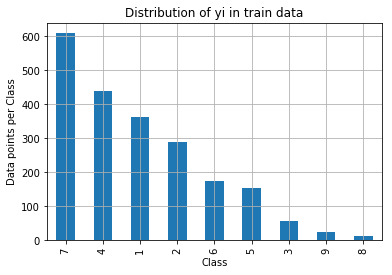

In [68]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [74]:
alpha=1
train_gene_feature_responseCoding=np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [78]:
cv_gene_feature_responseCoding

array([[0.10185185, 0.12037037, 0.09259259, ..., 0.19444444, 0.10185185,
        0.09259259],
       [0.12631579, 0.10526316, 0.10526316, ..., 0.10526316, 0.10526316,
        0.10526316],
       [0.08148148, 0.15555556, 0.07407407, ..., 0.21481481, 0.07407407,
        0.07407407],
       ...,
       [0.10982659, 0.05780347, 0.05780347, ..., 0.05780347, 0.05780347,
        0.05780347],
       [0.16239316, 0.08547009, 0.08547009, ..., 0.08547009, 0.08547009,
        0.08547009],
       [0.09243697, 0.10084034, 0.10084034, ..., 0.28571429, 0.08403361,
        0.08403361]])

In [77]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [86]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [123]:
text_vectorizer=CountVectorizer(ngram_range=(1,4))
train_text_feature_onehotCoding=text_vectorizer.fit_transform(train_df['TEXT'])


train_text_features=text_vectorizer.get_feature_names()
train_text_fea_counts=train_text_feature_onehotCoding.sum(axis=0).A1
text_fea_dict=dict(zip(list(train_text_features),train_text_fea_counts))

print("total unique words in train data :",len(train_text_features))

total unique words in train data : 12202457


In [154]:
train_text_feature_onehotCoding=normalize(train_text_feature_onehotCoding,axis=0)
test_text_feature_onehotCoding=text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding=normalize(test_text_feature_onehotCoding,axis=0)
cv_text_feature_onehotCoding=text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding=normalize(cv_text_feature_onehotCoding,axis=0)

### Data Preprocessing
#### Feature Stacking

In [155]:
train_gene_var_onehotCoding=hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding=hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding=hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

In [172]:
train_x_onehotCoding=hstack((train_gene_var_onehotCoding,train_text_feature_onehotCoding)).tocsr()
train_y=np.array(list(train_df['Class']))
test_x_onehotCoding=hstack((test_gene_var_onehotCoding,test_text_feature_onehotCoding)).tocsr()
test_y=np.array(list(test_df['Class']))
cv_x_onehotCoding=hstack((cv_gene_var_onehotCoding,cv_text_feature_onehotCoding)).tocsr()
cv_y=np.array(list(cv_df['Class']))

In [173]:
print("one hot encoding features")
print("data points * number of features in train data=",train_x_onehotCoding.shape)
print("data points * number of features in train data=",test_x_onehotCoding.shape)
print("data points * number of features in train data=",cv_x_onehotCoding.shape)

one hot encoding features
data points * number of features in train data= (2124, 12204655)
data points * number of features in train data= (665, 12204655)
data points * number of features in train data= (532, 12204655)


In [175]:
alpha=[10 ** x for x in range(-6,3)]

In [176]:
alpha

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [227]:
cv_log_error_array=[]
for i in alpha:
    print("for alpha=",i)
    clf=SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_x_onehotCoding,train_y)
    clf.predict(cv_x_onehotCoding)
    sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(train_x_onehotCoding,train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

best_alpha=np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha= 1e-06
Log Loss : 1.830499756776428
for alpha= 1e-05
Log Loss : 1.5829089499782698
for alpha= 0.0001
Log Loss : 1.5760445203292552
for alpha= 0.001
Log Loss : 1.4773223740525845
for alpha= 0.01
Log Loss : 1.2469418081804653
for alpha= 0.1
Log Loss : 1.2524112049911158
for alpha= 1
Log Loss : 1.2602707710185743
for alpha= 10
Log Loss : 1.2875905390994613
for alpha= 100
Log Loss : 1.2997817008556847
For values of best alpha =  0.01 The train log loss is: 0.7025794079584211
For values of best alpha =  0.01 The cross validation log loss is: 1.254732738620841
For values of best alpha =  0.01 The test log loss is: 1.2006418370038936


In [235]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

In [ ]:
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
pred_y = sig_clf.predict(cv_x_onehotCoding)

In [239]:
accuracy_score(pred_y,cv_y)

0.5657894736842105

In [207]:
clf2=RandomForestClassifier()
clf2.fit(train_x_onehotCoding,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [117]:
results=[0.8759005438723265,0.8330183131163407,0.774337391597264,0.8276394520246101]
names=["Logistic Regression","Random Forest","Gaussian NB","KNN"]

## 5. Final Model Metrics

In [119]:
data = {'Model Name': names,'AUC-ROC': results, }
dataset=pd.DataFrame(data)
dataset

,Model Name,AUC-ROC
0,Logistic Regression,0.875901
1,Random Forest,0.833018
2,Gaussian NB,0.774337
3,KNN,0.827639


## END